In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import os
import shutil
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

OSError: [WinError 182] 操作系统无法运行 %1。 Error loading "D:\Apps\Anaconda3\envs\python38\lib\site-packages\torch\lib\caffe2_detectron_ops.dll" or one of its dependencies.

In [59]:
class TransformerWithPhysics(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, num_heads, dropout=0.1):
        super(TransformerWithPhysics, self).__init__()
        
#         gpu_id = int(os.environ["LOCAL_RANK"])
#         device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
        
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads,\
                                                   dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, hidden_dim)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # Convert back to (batch_size, seq_len, hidden_dim)
        x = self.fc_out(x)
        return x

In [66]:
# 初始化模型
input_dim = 2  # 输入维度
hidden_dim = 128  # 隐藏层大小
output_dim = 5  # 输出维度
num_layers = 4  # Transformer层数
num_heads = 8  # 注意力头数

model = TransformerWithPhysics(input_dim, output_dim, hidden_dim, num_layers, num_heads)

# 加载已经训练好的模型参数
snapshot = torch.load("models/ld_tf_ddp_3/np/snapshot.pt")

model_state_dict = snapshot["model_state_dict"]
if 'module.' in next(iter(model_state_dict.keys())):
    model_state_dict = {k.replace('module.', ''): v for k, v in model_state_dict.items()}
model.load_state_dict(model_state_dict)
# model.load_state_dict(torch.load('models/model_LD_TF/3/transformer_model_epoch_0.pth'))

# 将模型移动到 GPU 上（如果有GPU的话）
device = torch.device('cuda:2' if torch.cuda.is_available() else
                      'cpu')
model.to(device)

# 将模型设置为评估模式，这会关闭 dropout 等层
model.eval()

TransformerWithPhysics(
  (embedding): Linear(in_features=2, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in

/lustre/home/sztu_pg_chenyue/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/lustre/home/sztu_pg_chenyue/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


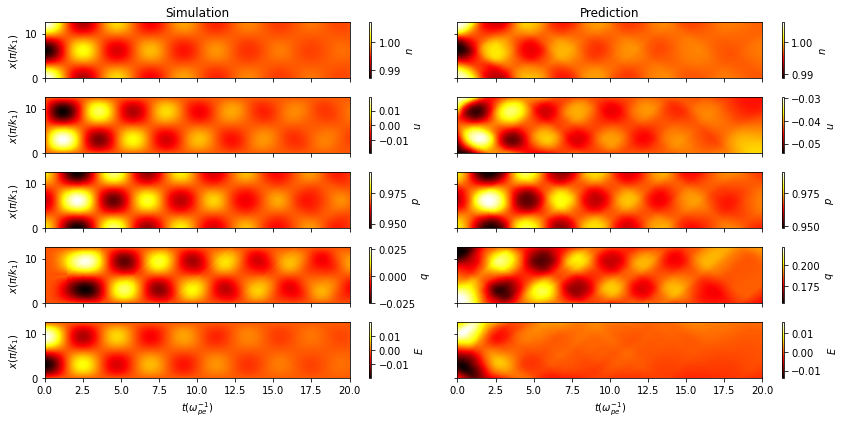

In [67]:
import os
import random
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

# 释放未使用的显存
torch.cuda.empty_cache()

# 加载数据
data = np.load('data/data_LD_6.npz')
X, T = data["X"].flatten(), data["T"].flatten()
Y_true = np.column_stack([(data[key]).flatten() for key in "nupqE"])

# 将 X 和 T 转换为 3D 形状 (batch_size, seq_len, input_dim)
batch_size = 200  # 适当减少批量大小
seq_len = len(X) // batch_size

X = torch.tensor(X, dtype=torch.float32).view(batch_size, seq_len, 1)
T = torch.tensor(T, dtype=torch.float32).view(batch_size, seq_len, 1)

# 使用模型进行预测
Y_pred = []

with torch.no_grad():
    for i in range(batch_size):
        x_tf = torch.cat((T[i:i+1], X[i:i+1]), dim=2).to(device)
        y_pred_batch = model(x_tf).cpu().numpy()
        Y_pred.append(y_pred_batch)

# 将预测结果转换为 NumPy 数组
Y_pred = np.concatenate(Y_pred, axis=0)

# 打印预测结果

Y_pred = Y_pred.reshape(-1, 5)
Y_pred.shape

t, x = T.detach().numpy(), X.detach().numpy()
t, x = t.reshape(2001, 200), x.reshape(2001, 200)

labels = ["n", "u", "p", "q", "E"]

fig, ax = plt.subplots(len(labels),2,sharex=True,sharey=True,figsize=(12,6))
for n in range(len(labels)):
    pcm = ax[n, 0].pcolormesh(t,x,Y_true[:,n].reshape(2001, 200),cmap="hot")
    fig.colorbar(pcm, ax=ax[n,0], label=f"${labels[n]}$")
    
    pcm = ax[n, 1].pcolormesh(t,x,Y_pred[:,n].reshape(2001, 200),cmap="hot")
    fig.colorbar(pcm, ax=ax[n,1], label=f"${labels[n]}$")
    ax[n, 0].set_ylabel("$x(\pi/k_1)$")

ax[n, 0].set_xlabel("$t(\omega_{pe}^{-1})$")
ax[n, 1].set_xlabel("$t(\omega_{pe}^{-1})$")
ax[0,0].set_title("Simulation")
ax[0,1].set_title("Prediction")
plt.tight_layout()
plt.show()

In [ ]:
Error = Y_true - Y_pred

fig, ax = plt.subplots(len(labels),1,sharex=True,sharey=True,figsize=(6,6))
for n in range(len(labels)):
    pcm = ax[n].pcolormesh(t,x,Error[:,n].reshape(2001, 200),cmap="hot")
    fig.colorbar(pcm, ax=ax[n], label=f"${labels[n]}$")
    
ax[n].set_xlabel("$t(\omega_{pe}^{-1})$")
ax[n].set_xlabel("$t(\omega_{pe}^{-1})$")
ax[0].set_title("Absolute Error")
plt.tight_layout()
plt.show()

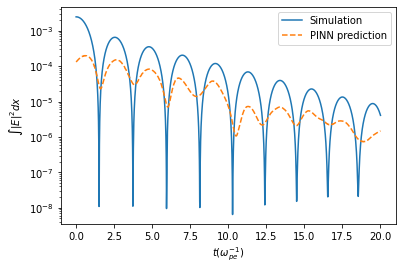

In [450]:
dx = x[0, 1] - x[0, 0]
t_val = t[:, 0]
E_true = Y_true[:,-1].reshape(2001, 200)
E_pred = Y_pred[:,-1].reshape(2001, 200)
energy_true = (E_true**2).sum(axis=1)*dx
energy_pred = (E_pred**2).sum(axis=1)*dx
plt.figure()
plt.semilogy(t_val, energy_true, label="Simulation")
plt.semilogy(t_val, energy_pred, '--', label="PINN prediction")
plt.xlabel("$t (\omega_{pe}^{-1})$")
plt.ylabel("$\int |E|^2 dx$")
plt.legend()

In [358]:
min(energy_true)

6.461642661094666e-09

In [1207]:
weights_history = [
    np.load('models/ld_tf_ddp_1/1/weights_epoch_0.npz', allow_pickle=True),
    np.load('models/ld_tf_ddp_1/1/weights_epoch_10.npz', allow_pickle=True)
    # 添加其他权重文件...
]

In [682]:
# 列出所有保存的权重矩阵名称
print("Available weight matrices:")
for key in weights_history[0].files:
    print(key)

Available weight matrices:
embedding_weight
transformer_weights
fc_out_weight


In [683]:
weights_history[0]['transformer_weights'][0]['linear2_weight'].shape

(128, 2048)

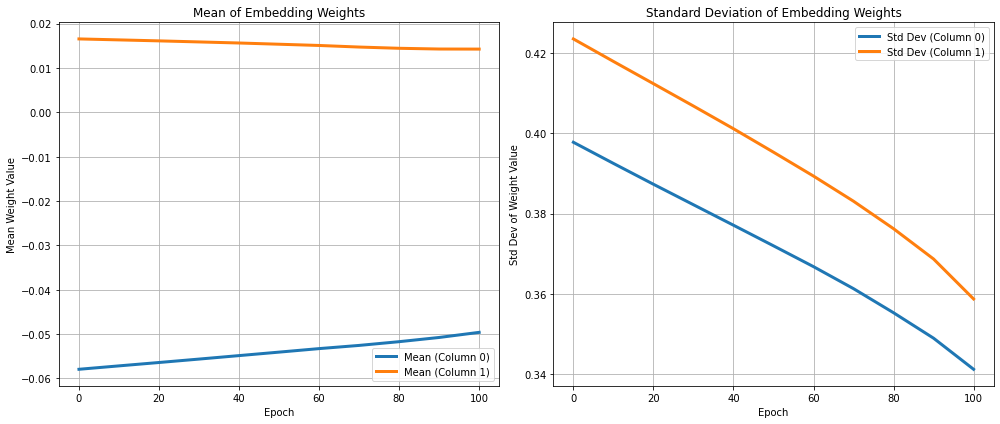

In [1208]:
# 示例路径和保存频率
snapshot_path = "models/ld_tf_ddp_1/4/snapshot.pt"
max_epochs = 100
save_every = 10

weights_history = []

# 遍历所有保存的 epoch
for epoch in range(0, max_epochs + 1, save_every):
    weight_file_path = os.path.join(os.path.dirname(snapshot_path), f'weights_epoch_{epoch}.npz')
    if os.path.exists(weight_file_path):
        loaded_weights = np.load(weight_file_path, allow_pickle=True)
        weights_history.append(loaded_weights)
    else:
        print(f"Weight file for epoch {epoch} does not exist.")

# 提取和拼接 embedding_weight
embedding_weights = []
for weights in weights_history:
    embedding_weight = weights['embedding_weight']  # 确保 'embedding_weight' 键存在
    embedding_weights.append(embedding_weight)

# 计算每个 epoch 权重的均值和标准差
mean_weights = []
std_weights = []
for weight in embedding_weights:
    mean_weights.append(np.mean(weight, axis=0))  # 沿着行方向计算均值
    std_weights.append(np.std(weight, axis=0))    # 沿着行方向计算标准差

mean_weights = np.array(mean_weights)
std_weights = np.array(std_weights)

# 绘制均值和标准差
epochs = range(0, max_epochs + 1, save_every)

plt.figure(figsize=(14, 6))

# 绘制均值
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_weights[:, 0], linewidth=3, label='Mean (Column 0)')
plt.plot(epochs, mean_weights[:, 1], linewidth=3, label='Mean (Column 1)')
plt.xlabel('Epoch')
plt.ylabel('Mean Weight Value')
plt.title('Mean of Embedding Weights')
plt.legend()
plt.grid(True)

# 绘制标准差
plt.subplot(1, 2, 2)
plt.plot(epochs, std_weights[:, 0], linewidth=3, label='Std Dev (Column 0)')
plt.plot(epochs, std_weights[:, 1], linewidth=3, label='Std Dev (Column 1)')
plt.xlabel('Epoch')
plt.ylabel('Std Dev of Weight Value')
plt.title('Standard Deviation of Embedding Weights')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


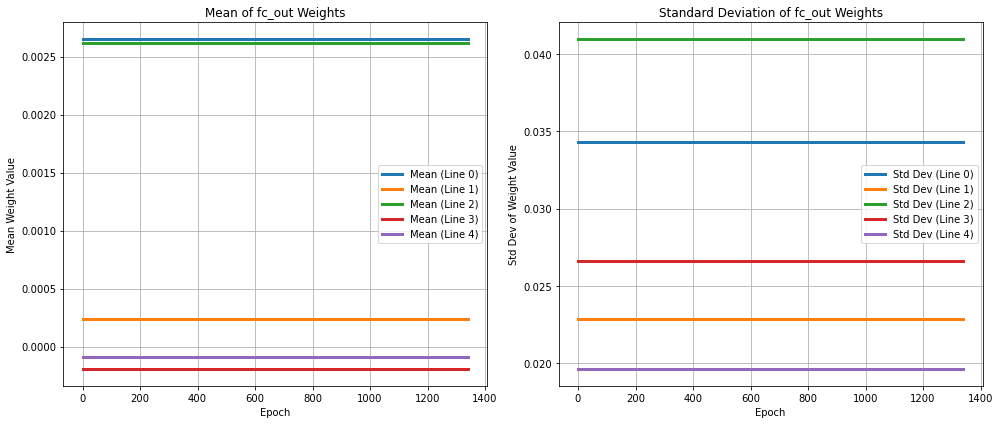

In [1102]:
# 提取和拼接 embedding_weight
fc_out_weights = []
for weights in weights_history:
    fc_out_weight = weights['fc_out_weight'].T  # 确保 'embedding_weight' 键存在
    fc_out_weights.append(fc_out_weight)

# 计算每个 epoch 权重的均值和标准差
mean_fc_out_weights = []
std_fc_out_weights = []
for weight in fc_out_weights:
    mean_fc_out_weights.append(np.mean(fc_out_weight, axis=0))  # 沿着列方向计算均值
    std_fc_out_weights.append(np.std(fc_out_weight, axis=0))    # 沿着列方向计算标准差

mean_fc_out_weights = np.array(mean_fc_out_weights)
std_fc_out_weights = np.array(std_fc_out_weights)

# 绘制均值和标准差
epochs = range(0, max_epochs + 1, save_every)

plt.figure(figsize=(14, 6))

# 绘制均值
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_fc_out_weights[:, 0], linewidth=3, label='Mean (Line 0)')
plt.plot(epochs, mean_fc_out_weights[:, 1], linewidth=3, label='Mean (Line 1)')
plt.plot(epochs, mean_fc_out_weights[:, 2], linewidth=3, label='Mean (Line 2)')
plt.plot(epochs, mean_fc_out_weights[:, 3], linewidth=3, label='Mean (Line 3)')
plt.plot(epochs, mean_fc_out_weights[:, 4], linewidth=3, label='Mean (Line 4)')
plt.xlabel('Epoch')
plt.ylabel('Mean Weight Value')
plt.title('Mean of fc_out Weights')
plt.legend()
plt.grid(True)

# 绘制标准差
plt.subplot(1, 2, 2)
plt.plot(epochs, std_fc_out_weights[:, 0], linewidth=3, label='Std Dev (Line 0)')
plt.plot(epochs, std_fc_out_weights[:, 1], linewidth=3, label='Std Dev (Line 1)')
plt.plot(epochs, std_fc_out_weights[:, 2], linewidth=3, label='Std Dev (Line 2)')
plt.plot(epochs, std_fc_out_weights[:, 3], linewidth=3, label='Std Dev (Line 3)')
plt.plot(epochs, std_fc_out_weights[:, 4], linewidth=3, label='Std Dev (Line 4)')
plt.xlabel('Epoch')
plt.ylabel('Std Dev of Weight Value')
plt.title('Standard Deviation of fc_out Weights')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

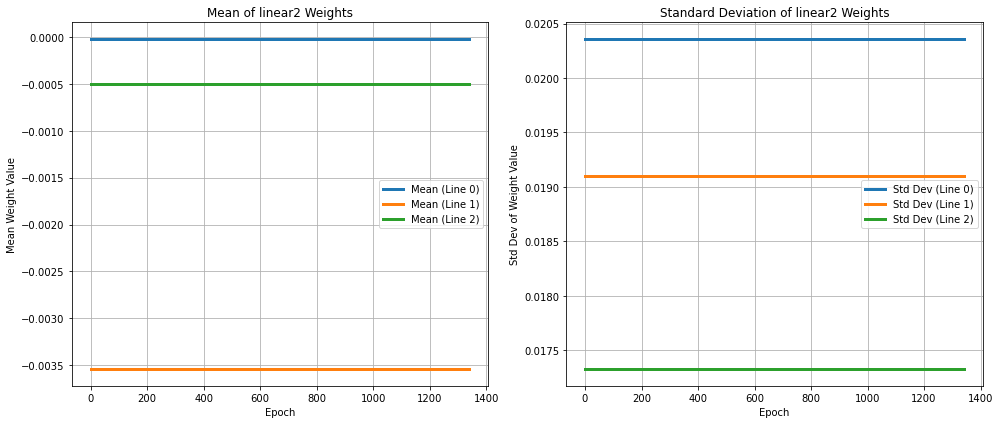

In [1103]:
linear2_weights = []
for weights in weights_history:
    linear2_weight = weights['transformer_weights'][0]['linear2_weight'].T  # 确保 'embedding_weight' 键存在
    linear2_weights.append(linear2_weight)

# 计算每个 epoch 权重的均值和标准差
mean_linear2_weights = []
std_linear2_weights = []
for weight in linear2_weights:
    mean_linear2_weights.append(np.mean(linear2_weight, axis=0))  # 沿着列方向计算均值
    std_linear2_weights.append(np.std(linear2_weight, axis=0))    # 沿着列方向计算标准差

mean_linear2_weights = np.array(mean_linear2_weights)
std_linear2_weights = np.array(std_linear2_weights)

# 绘制均值和标准差
epochs = range(0, max_epochs + 1, save_every)

plt.figure(figsize=(14, 6))

# 绘制均值
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_linear2_weights[:, 0], linewidth=3, label='Mean (Line 0)')
plt.plot(epochs, mean_linear2_weights[:, 1], linewidth=3, label='Mean (Line 1)')
plt.plot(epochs, mean_linear2_weights[:, 2], linewidth=3, label='Mean (Line 2)')
plt.xlabel('Epoch')
plt.ylabel('Mean Weight Value')
plt.title('Mean of linear2 Weights')
plt.legend()
plt.grid(True)

# 绘制标准差
plt.subplot(1, 2, 2)
plt.plot(epochs, std_linear2_weights[:, 0], linewidth=3, label='Std Dev (Line 0)')
plt.plot(epochs, std_linear2_weights[:, 1], linewidth=3, label='Std Dev (Line 1)')
plt.plot(epochs, std_linear2_weights[:, 2], linewidth=3, label='Std Dev (Line 2)')
plt.xlabel('Epoch')
plt.ylabel('Std Dev of Weight Value')
plt.title('Standard Deviation of linear2 Weights')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

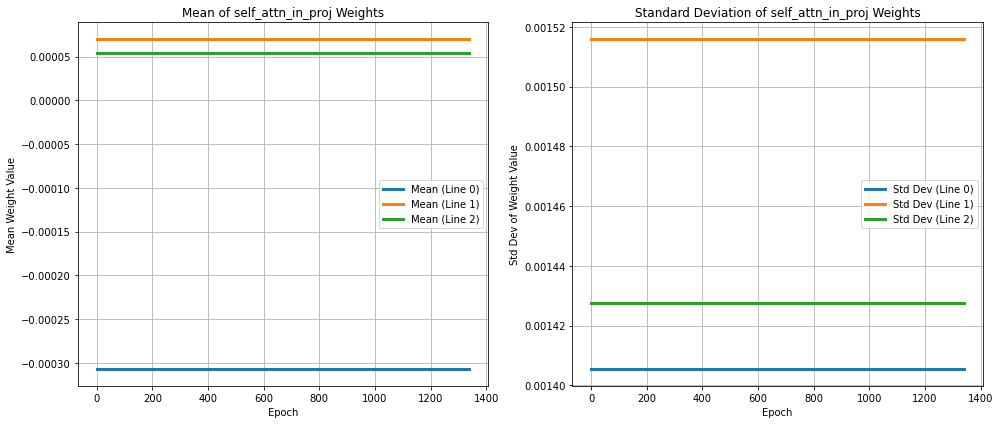

In [1104]:
self_attn_in_proj_weights = []
for weights in weights_history:
    self_attn_in_proj_weight = weights['transformer_weights'][0]['self_attn_in_proj_weight'].T  # 确保 'embedding_weight' 键存在
    self_attn_in_proj_weights.append(self_attn_in_proj_weight)

# 计算每个 epoch 权重的均值和标准差
mean_self_attn_in_proj_weights = []
std_self_attn_in_proj_weights = []
for weight in self_attn_in_proj_weights:
    mean_self_attn_in_proj_weights.append(np.mean(self_attn_in_proj_weight, axis=0))  # 沿着列方向计算均值
    std_self_attn_in_proj_weights.append(np.std(self_attn_in_proj_weight, axis=0))    # 沿着列方向计算标准差

mean_self_attn_in_proj_weights = np.array(mean_self_attn_in_proj_weights)
std_self_attn_in_proj_weights = np.array(std_self_attn_in_proj_weights)

# 绘制均值和标准差
epochs = range(0, max_epochs + 1, save_every)

plt.figure(figsize=(14, 6))

# 绘制均值
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_self_attn_in_proj_weights[:, 0], linewidth=3, label='Mean (Line 0)')
plt.plot(epochs, mean_self_attn_in_proj_weights[:, 1], linewidth=3, label='Mean (Line 1)')
plt.plot(epochs, mean_self_attn_in_proj_weights[:, 2], linewidth=3, label='Mean (Line 2)')
plt.xlabel('Epoch')
plt.ylabel('Mean Weight Value')
plt.title('Mean of self_attn_in_proj Weights')
plt.legend()
plt.grid(True)

# 绘制标准差
plt.subplot(1, 2, 2)
plt.plot(epochs, std_self_attn_in_proj_weights[:, 0], linewidth=3, label='Std Dev (Line 0)')
plt.plot(epochs, std_self_attn_in_proj_weights[:, 1], linewidth=3, label='Std Dev (Line 1)')
plt.plot(epochs, std_self_attn_in_proj_weights[:, 2], linewidth=3, label='Std Dev (Line 2)')
plt.xlabel('Epoch')
plt.ylabel('Std Dev of Weight Value')
plt.title('Standard Deviation of self_attn_in_proj Weights')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [1284]:
from transformers import Adafactor
from torch.cuda.amp import autocast, GradScaler